## Preparing the data

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# change working directory to model folder
os.chdir("C:\\Users\\brian\\Desktop\\minor\\AI project\\model")

# save the data from the csv file and divide Pawpularity score by 100
train_data = pd.read_csv('petfinder-pawpularity-score/train.csv')
train_data['Pawpularity'] = train_data['Pawpularity']

# check if the data was read correctly and if there are NaN values
display(train_data.head(5))
print(f'NaN amount: {train_data.isnull().sum().sum()}')

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


NaN amount: 0


In [3]:
def load_images_from_folder(folder, data = [], size=128):
    """
    This function takes a folder in which the images are saved, a dataframe of tabular data and size.
    It loads in an image finds the corresponding name and Pawpularity score and saves those so that they are ordered.
    It returns an array of images, a list of labels and a list of names.
    """
    # create empty lists for the data
    images = []
    labels = []
    names = []
    
    # iterate over all images in the given folder
    for filename in os.listdir(folder):
        
        # extract the name from the image
        name = filename.strip('.jpg')
        
        # add the name to the list of names
        names.append(name)
        
        # use the name to find the corresponding pawpularity score and add it to the list of scores
        labels.append(data.loc[data['Id']== name]['Pawpularity'].item())
        
        # resize the image to the given size and add it to the list of images
        img = cv2.resize(cv2.imread(os.path.join(folder,filename)), (size, size))
        if img is not None:
            images.append(img)
            
    # return the array of images and lists of labels and names
    return np.array(images), labels, names

data_images, data_labels, data_names = load_images_from_folder('petfinder-pawpularity-score/train', data = train_data)

print(f'Images loaded: {data_images.shape}')

Images loaded: (9912, 128, 128, 3)


In [4]:
# split the data into 67% training data and 33% testing data
image_train, image_test, label_train, label_test, name_train, name_test = train_test_split(data_images, data_labels, data_names, test_size=0.33, random_state=42)

In [5]:
# check if the labels match the names of the images
print('checking training data: ')
print(label_train[0])
print(name_train[0])

checking training data: 
17
1f7f000086edf5e4c0f5a8e4d93f157d


## Making the image model

In [6]:
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing, utils
import tensorflow as tf

In [7]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    ''' Make the model to train and evaluate the data'''

    # compile the model using adam as optimizer with mean squared error as loss function
    model.compile(optimizer='adam',
              loss='MSE',
              metrics=['RootMeanSquaredError'])

    train_gen = preprocessing.image.ImageDataGenerator(preprocess, augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    # estimate the model using the compile 
    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    # plot the learning curves
    for i, metric in enumerate(['loss', 'RootMeanSquaredError']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 208 steps, validate for 103 steps
Epoch 1/16
208/208 [==============================] - 15s 71ms/step - loss: 647.2159 - RootMeanSquaredError: 25.4264 - val_loss: 538.2803 - val_RootMeanSquaredError: 23.2262
Epoch 2/16
208/208 [==============================] - 10s 48ms/step - loss: 544.8410 - RootMeanSquaredError: 23.3197 - val_loss: 565.4615 - val_RootMeanSquaredError: 23.8065
Epoch 3/16
208/208 [==============================] - 10s 47ms/step - loss: 522.9258 - RootMeanSquaredError: 22.8507 - val_loss: 502.6220 - val_RootMeanSquaredError: 22.4427
Epoch 4/16
208/208 [==============================] - 10s 47ms/step - loss: 510.1361 - RootMeanSquaredError: 22.5646 - val_loss: 487.0733 - val_RootMeanSquaredError: 22.0919
Epoch 5/16
208/208 [==============================] - 10s 47ms/step - loss: 491.3446 - RootMeanSquaredError: 22.1563 - val_loss: 442.3769 - val_RootMeanSquaredError: 21.0441
Epoch 6/16
208/208 [================

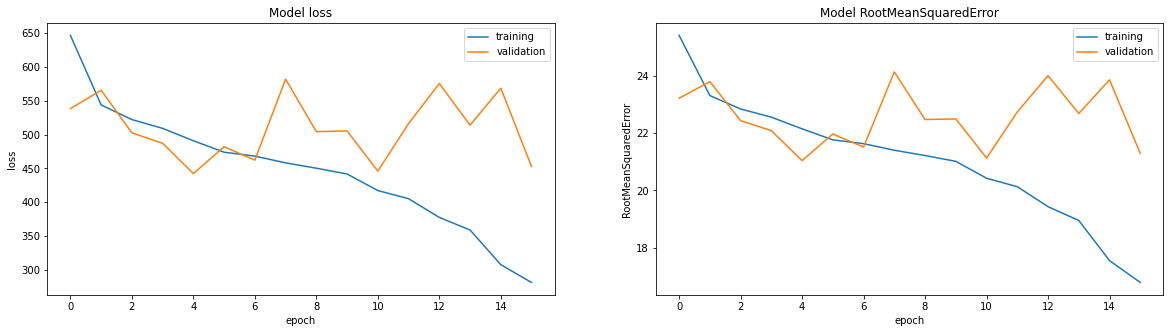

  ...
    to  
  ['...']
103/103 [==============================] - 1s 13ms/step - loss: 450.4282 - RootMeanSquaredError: 21.2937
Validation Accuracy: 21.293701171875


In [8]:
# create the CNN model by adding the layers
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(128,128,3),padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# second layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# third layer
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# fourth layer
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())


model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(512,activation='relu'))

model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(256,activation='relu'))

model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128,activation='relu'))

model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation=None))

preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# train the model and evaluate it with the test_data
train_and_evaluate(model, image_train, label_train, image_test, label_test, preprocess, epochs=16)

This dataset is from a competition in which you have to estimate the 8 images below, these are our scores as of now.

In [9]:
test_images = []
test_names = []

# iterate over the test images
for filename in os.listdir('petfinder-pawpularity-score/test'):
    
    # get the names of the test images and save these in the list
    name = filename.strip('.jpg')
    test_names.append(name)
    
    # save the images 
    img = cv2.imread(os.path.join('petfinder-pawpularity-score/test',filename))
    if img is not None:
        test_images.append(img)

In [10]:
# convert the list of images to an array
test_images = np.array(test_images)

# use the model to predict the pawpularity scores of the test images
model.predict(test_images)

array([[34.538834],
       [36.815617],
       [35.75768 ],
       [34.47796 ],
       [34.48319 ],
       [34.97082 ],
       [34.463966],
       [35.433342]], dtype=float32)